# 2kr Analysis (High Density Scenario)

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)
    transformations.append((v[0], lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## 2kr

In [9]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1.000000,1.00000,1.000000,0.999110,0.999110,1.00000,1.000000,0.997331,0.997331,0.999110,0.999199,0.000801,0.000801,0.000801,-0.000089,-0.000089,0.000801,0.000801,-0.001868,-0.001868,-0.000089
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1.000000,1.00000,1.000000,0.998221,0.998221,1.00000,1.000000,1.000000,0.999110,0.999110,0.999466,0.000534,0.000534,0.000534,-0.001246,-0.001246,0.000534,0.000534,0.000534,-0.000356,-0.000356
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1.000000,1.00000,0.997331,1.000000,1.000000,1.00000,0.998221,1.000000,1.000000,1.000000,0.999555,0.000445,0.000445,-0.002224,0.000445,0.000445,0.000445,-0.001335,0.000445,0.000445,0.000445
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1.000000,1.00000,0.998221,1.000000,1.000000,1.00000,1.000000,0.998221,1.000000,0.998221,0.999466,0.000534,0.000534,-0.001246,0.000534,0.000534,0.000534,0.000534,-0.001246,0.000534,-0.001246
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,0.999110,1.00000,1.000000,0.999110,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.999822,-0.000712,0.000178,0.000178,-0.000712,0.000178,0.000178,0.000178,0.000178,0.000178,0.000178
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,0.998221,0.99911,1.000000,1.000000,0.999110,1.00000,1.000000,0.997331,1.000000,1.000000,0.999377,-0.001157,-0.000267,0.000623,0.000623,-0.000267,0.000623,0.000623,-0.002046,0.000623,0.000623
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.000000,1.00000,1.000000,1.000000,0.998221,1.00000,1.000000,1.000000,1.000000,1.000000,0.999822,0.000178,0.000178,0.000178,0.000178,-0.001601,0.000178,0.000178,0.000178,0.000178,0.000178
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1.000000,1.00000,1.000000,0.999110,1.000000,0.99911,0.999110,1.000000,0.999110,1.000000,0.999644,0.000356,0.000356,0.000356,-0.000534,0.000356,-0.000534,-0.000534,0.000356,-0.000534,0.000356


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.995285,0.001868,0.000979,-0.000267,0.000801,0.000445,0.000267,0.000623,0.000089,0.000801,0.00169,-0.000089,-0.002224,-0.000267,-0.000801,0.000801,0.000267,0.003824,-0.000623,-0.000623,-0.000623,0.003824,-0.000623,-0.003289,-0.000622,-0.001512
Mean (Qi),0.999705,0.000117,0.000061,-0.000017,0.00005,0.000028,0.000017,0.000039,0.000006,0.00005,0.000106,-0.000006,-0.000139,-0.000017,-0.00005,0.00005,0.000017,0.000239,-0.000039,-0.000039,-0.000039,0.000239,-0.000039,-0.000206,-0.000039,-0.000094
SSQ,,,,,,,,,,,,,,,,,0.000005,0.000002,0.000008,0.000004,0.000005,0.000003,0.000006,0.000011,0.000005,0.000005


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.000002,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.000003,0.0,0.0,0.0,0.000055
Variation,0.033842,0.009286,0.000691,0.006216,0.001919,0.000691,0.00376,0.000077,0.006216,0.027703,0.000077,0.047963,0.000691,0.006216,0.006216,0.000064
Variation%,3.38%,0.93%,0.07%,0.62%,0.19%,0.07%,0.38%,0.01%,0.62%,2.77%,0.01%,4.80%,0.07%,0.62%,0.62%,84.84%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),0.000213,0.000157,0.00008,0.000146,0.000124,0.000113,0.000135,0.000102,0.000146,0.000202,0.000091,-0.000043,0.00008,0.000046,0.000146
CI- Qi (95.00%),0.00002,-0.000035,-0.000113,-0.000046,-0.000069,-0.00008,-0.000057,-0.000091,-0.000046,0.000009,-0.000102,-0.000235,-0.000113,-0.000146,-0.000046
Distance (Qi),0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193
Zero Included,False,True,True,True,True,True,True,True,True,False,True,False,True,True,True
CI+ Variation,0.112683,0.061544,0.015735,0.053158,0.038228,0.031684,0.045386,0.025754,0.053158,0.101227,0.020437,0.004527,0.015735,0.005311,0.053158
CI- Variation,0.00104,0.003065,0.031684,0.005311,0.011647,0.015735,0.008172,0.020437,0.005311,0.000217,0.025754,0.137436,0.031684,0.053158,0.005311
CI Distance (Variation),0.111643,0.05848,0.015949,0.047847,0.026582,0.015949,0.037214,0.005316,0.047847,0.101011,0.005316,0.132909,0.015949,0.047847,0.047847


SSE = 5.469472271121314e-05
SST = 6.446517109712335e-05
Error variance = 3.798244632723135e-07
Unexplained Variation = 84.84%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,831.0,906.0,799.0,822.0,844.0,850.0,880.0,864.0,884.0,830.0,851.0,-20.0,55.0,-52.0,-29.0,-7.0,-1.0,29.0,13.0,33.0,-21.0
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,560.0,493.0,561.0,484.0,497.0,448.0,532.0,627.0,502.0,488.0,519.2,40.8,-26.2,41.8,-35.2,-22.2,-71.2,12.8,107.8,-17.2,-31.2
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,980.0,1006.0,919.0,1034.0,1036.0,960.0,968.0,1031.0,1006.0,965.0,990.5,-10.5,15.5,-71.5,43.5,45.5,-30.5,-22.5,40.5,15.5,-25.5
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,595.0,553.0,548.0,558.0,661.0,623.0,670.0,538.0,555.0,611.0,591.2,3.8,-38.2,-43.2,-33.2,69.8,31.8,78.8,-53.2,-36.2,19.8
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,820.0,739.0,713.0,722.0,803.0,774.0,755.0,724.0,699.0,675.0,742.4,77.6,-3.4,-29.4,-20.4,60.6,31.6,12.6,-18.4,-43.4,-67.4
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,455.0,560.0,395.0,343.0,473.0,460.0,450.0,492.0,439.0,402.0,446.9,8.1,113.1,-51.9,-103.9,26.1,13.1,3.1,45.1,-7.9,-44.9
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1014.0,1003.0,948.0,973.0,972.0,964.0,930.0,1062.0,1005.0,911.0,978.2,35.8,24.8,-30.2,-5.2,-6.2,-14.2,-48.2,83.8,26.8,-67.2
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,621.0,661.0,623.0,647.0,676.0,754.0,681.0,682.0,703.0,676.0,672.4,-51.4,-11.4,-49.4,-25.4,3.6,81.6,8.6,9.6,30.6,3.6
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4221.0,4431.0,4176.0,4109.0,4017.0,4263.0,4386.0,4275.0,4044.0,3990.0,4191.2,29.8,239.8,-15.2,-82.2,-174.2,71.8,194.8,83.8,-147.2,-201.2


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,35984.6,24401.0,330.8,6479.6,-6908.0,554.8,5134.0,-4243.2,3308.2,1268.2,32.2,2808.6,1008.6,187.8,353.2,238.8,248358.70000,476534.000,1.696300e+06,-3.006648e+06,-2178839.600,1984221.60,92038.4,1.745773e+06,207845.30000,-1.265582e+06
Mean (Qi),2249.0375,1525.0625,20.675,404.975,-431.75,34.675,320.875,-265.2,206.7625,79.2625,2.0125,175.5375,63.0375,11.7375,22.075,14.925,15522.41875,29783.375,1.060187e+05,-1.879155e+05,-136177.475,124013.85,5752.4,1.091108e+05,12990.33125,-7.909891e+04
SSQ,,,,,,,,,,,,,,,,,140673.10000,252546.500,1.721215e+05,1.540643e+05,473016.700,146854.30,291976.7,2.536735e+05,335314.90000,2.461215e+05


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,372130500.625,68392.9,26240760.1,29825290.0,192376.9,16473722.5,11252966.4,6840117.025,1005207.025,648.025,4930146.225,635796.225,22043.025,77968.9,35640.9,2466363.0
Variation,0.788082,0.000145,0.055572,0.063163,0.000407,0.034887,0.023831,0.014486,0.002129,0.000001,0.010441,0.001346,0.000047,0.000165,0.000075,472197939.775
Variation%,78.81%,0.01%,5.56%,6.32%,0.04%,3.49%,2.38%,1.45%,0.21%,0.00%,1.04%,0.13%,0.00%,0.02%,0.01%,0.52%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),1545.512842,41.125342,425.425342,-411.299658,55.125342,341.325342,-244.749658,227.212842,99.712842,22.462842,195.987842,83.487842,32.187842,42.525342,35.375342
CI- Qi (95.00%),1504.612158,0.224658,384.524658,-452.200342,14.224658,300.424658,-285.650342,186.312158,58.812158,-18.437842,155.087158,42.587158,-8.712842,1.624658,-5.525342
Distance (Qi),40.900684,40.900684,40.900684,40.900684,40.900684,40.900684,40.900684,40.900684,40.900684,40.900684,40.900684,40.900684,40.900684,40.900684,40.900684
Zero Included,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True
CI+ Variation,0.809359,0.000573,0.061326,0.057321,0.00103,0.039476,0.020297,0.017493,0.003369,0.000171,0.013015,0.002362,0.000351,0.000613,0.000424
CI- Variation,0.767088,0.0,0.050101,0.069288,0.000069,0.030582,0.027648,0.011762,0.001172,0.000115,0.00815,0.000615,0.000026,0.000001,0.00001
CI Distance (Variation),0.042271,0.000573,0.011225,0.011967,0.000961,0.008894,0.007351,0.005731,0.002197,0.000056,0.004865,0.001747,0.000325,0.000612,0.000414


SSE = 2466363.0000000005
SST = 472197939.77499986
Error variance = 17127.520833333336
Unexplained Variation = 0.52%

####################################

2^k*r analysis for the total number of messages sent


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,978.0,981.0,966.0,978.0,981.0,969.0,980.0,963.0,984.0,975.0,975.5,2.5,5.5,-9.5,2.5,5.5,-6.5,4.5,-12.5,8.5,-0.5
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1021.0,1009.0,1028.0,1011.0,1018.0,993.0,980.0,1036.0,992.0,986.0,1007.4,13.6,1.6,20.6,3.6,10.6,-14.4,-27.4,28.6,-15.4,-21.4
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1125.0,1125.0,1125.0,1123.0,1123.0,1125.0,1125.0,1125.0,1124.0,1124.0,1124.4,0.6,0.6,0.6,-1.4,-1.4,0.6,0.6,0.6,-0.4,-0.4
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1125.0,1125.0,1122.0,1125.0,1125.0,1125.0,1123.0,1125.0,1125.0,1125.0,1124.5,0.5,0.5,-2.5,0.5,0.5,0.5,-1.5,0.5,0.5,0.5
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,899.0,891.0,866.0,869.0,899.0,899.0,882.0,882.0,892.0,901.0,888.0,11.0,3.0,-22.0,-19.0,11.0,11.0,-6.0,-6.0,4.0,13.0
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,825.0,867.0,845.0,810.0,869.0,845.0,862.0,870.0,837.0,823.0,845.3,-20.3,21.7,-0.3,-35.3,23.7,-0.3,16.7,24.7,-8.3,-22.3
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1123.0,1124.0,1123.0,1123.0,1124.0,1116.0,1124.0,1122.0,1122.0,1125.0,1122.6,0.4,1.4,0.4,0.4,1.4,-6.6,1.4,-0.6,-0.6,2.4
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1122.0,1123.0,1120.0,1125.0,1123.0,1125.0,1121.0,1120.0,1120.0,1121.0,1122.0,0.0,1.0,-2.0,3.0,1.0,3.0,-1.0,-2.0,-2.0,-1.0
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,973.0,1026.0,1014.0,969.0,970.0,997.0,1034.0,1002.0,942.0,947.0,987.4,-14.4,38.6,26.6,-18.4,-17.4,9.6,46.6,14.6,-45.4,-40.4


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15819.1,-600.3,-991.9,2134.7,-200.3,-484.1,580.1,-177.7,952.5,-164.5,190.9,461.9,-13.9,170.3,152.3,4.5,-17497.410000,75829.790000,47712.190000,-104433.010000,-57767.810000,19217.990000,4476.190000,74671.290000,10012.590000,-52221.810000
Mean (Qi),988.69375,-37.51875,-61.99375,133.41875,-12.51875,-30.25625,36.25625,-11.10625,59.53125,-10.28125,11.93125,28.86875,-0.86875,10.64375,9.51875,0.28125,-1093.588125,4739.361875,2982.011875,-6527.063125,-3610.488125,1201.124375,279.761875,4666.955625,625.786875,-3263.863125
SSQ,,,,,,,,,,,,,,,,,1170.410000,2491.010000,4227.210000,6714.610000,7026.210000,2737.610000,7699.210000,5183.010000,5811.410000,4974.210000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,225225.05625,614916.00625,2848090.05625,25075.05625,146470.50625,210322.50625,19735.80625,567035.15625,16912.65625,22776.75625,133344.75625,120.75625,18126.30625,14497.05625,12.65625,48034.9
Variation,0.045864,0.12522,0.579977,0.005106,0.029827,0.042829,0.004019,0.115469,0.003444,0.004638,0.027154,0.000025,0.003691,0.002952,0.000003,4910695.99375
Variation%,4.59%,12.52%,58.00%,0.51%,2.98%,4.28%,0.40%,11.55%,0.34%,0.46%,2.72%,0.00%,0.37%,0.30%,0.00%,0.98%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-34.664773,-59.139773,136.272727,-9.664773,-27.402273,39.110227,-8.252273,62.385227,-7.427273,14.785227,31.722727,1.985227,13.497727,12.372727,3.135227
CI- Qi (95.00%),-40.372727,-64.847727,130.564773,-15.372727,-33.110227,33.402273,-13.960227,56.677273,-13.135227,9.077273,26.014773,-3.722727,7.789773,6.664773,-2.572727
Distance (Qi),5.707955,5.707955,5.707955,5.707955,5.707955,5.707955,5.707955,5.707955,5.707955,5.707955,5.707955,5.707955,5.707955,5.707955,5.707955
Zero Included,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
CI+ Variation,0.039152,0.113956,0.605055,0.003043,0.024465,0.049838,0.002219,0.126806,0.001797,0.007123,0.032788,0.000128,0.005936,0.004988,0.00032
CI- Variation,0.053107,0.137014,0.55543,0.0077,0.035719,0.036352,0.00635,0.104663,0.005621,0.002685,0.02205,0.000452,0.001977,0.001447,0.000216
CI Distance (Variation),0.013955,0.023059,0.049625,0.004656,0.011254,0.013486,0.004131,0.022143,0.003824,0.004438,0.010738,0.000323,0.003959,0.003541,0.000105


SSE = 48034.899999999994
SST = 4910695.99375
Error variance = 333.5756944444444
Unexplained Variation = 0.98%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,3.526361,3.583519,4.043051,3.526361,4.127134,3.784190,4.143135,4.060443,3.583519,3.663562,3.804127,-0.277767,-0.220608,0.238924,-0.277767,0.323007,-0.019938,0.339007,0.256316,-0.220608,-0.140566
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,3.663562,3.713572,4.262680,4.174387,4.043051,3.737670,3.761200,3.610918,3.713572,4.025352,3.870596,-0.207035,-0.157024,0.392084,0.303791,0.172455,-0.132927,-0.109396,-0.259678,-0.157024,0.154755
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,3.610918,3.828641,3.688879,3.850148,3.850148,4.143135,3.737670,3.526361,3.637586,3.465736,3.733922,-0.123004,0.094719,-0.045043,0.116226,0.116226,0.409213,0.003748,-0.207562,-0.096336,-0.268186
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,3.761200,3.871201,3.891820,3.761200,4.189655,3.912023,4.204693,4.025352,3.951244,3.912023,3.948041,-0.186841,-0.076840,-0.056221,-0.186841,0.241614,-0.036018,0.256652,0.077311,0.003203,-0.036018
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.430817,4.234107,4.189655,4.634729,4.094345,4.204693,4.442651,4.330733,4.418841,4.262680,4.324325,0.106492,-0.090218,-0.134670,0.310404,-0.229980,-0.119632,0.118326,0.006408,0.094516,-0.061645
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.330733,4.143135,4.262680,4.304065,4.499810,4.564348,4.234107,4.564348,4.317488,4.465908,4.368662,-0.037929,-0.225527,-0.105982,-0.064597,0.131147,0.195686,-0.134556,0.195686,-0.051174,0.097246
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.330733,4.158883,4.644391,4.844187,4.174387,4.442651,4.189655,4.369448,4.442651,4.672829,4.426982,-0.096248,-0.268098,0.217409,0.417206,-0.252594,0.015670,-0.237327,-0.057534,0.015670,0.245847
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.204693,4.262680,4.143135,4.521789,4.317488,4.521789,4.477337,4.290459,4.189655,4.394449,4.332347,-0.127655,-0.069667,-0.189213,0.189441,-0.014859,0.189441,0.144990,-0.041888,-0.142693,0.062102
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,2.639057,3.091042,2.890372,2.944439,2.639057,2.639057,3.295837,2.639057,2.995732,2.995732,2.876938,-0.237881,0.214104,0.013433,0.067501,-0.237881,-0.237881,0.418898,-0.237881,0.118794,0.118794


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,57.989607,-7.628398,4.334384,0.002951,0.373614,0.143126,-0.144211,-0.086968,0.046849,-0.267197,0.078614,-0.071356,0.394573,0.061257,-0.311602,0.261641,-2.220732,-4.174802,0.579128,2.597251,3.426697,2.589206,2.453633,-2.037081,-4.098992,0.885692
Mean (Qi),3.62435,-0.476775,0.270899,0.000184,0.023351,0.008945,-0.009013,-0.005435,0.002928,-0.0167,0.004913,-0.00446,0.024661,0.003829,-0.019475,0.016353,-0.138796,-0.260925,0.036195,0.162328,0.214169,0.161825,0.153352,-0.127318,-0.256187,0.055356
SSQ,,,,,,,,,,,,,,,,,0.742678,0.487149,0.474305,0.910710,0.765946,0.523481,0.849139,0.464701,0.335809,0.364292


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,36.370287,11.741802,0.000005,0.087242,0.012803,0.012998,0.004727,0.001372,0.044621,0.003863,0.003182,0.097305,0.002345,0.060685,0.042785,5.91821
Variation,0.668519,0.215825,0.0,0.001604,0.000235,0.000239,0.000087,0.000025,0.00082,0.000071,0.000058,0.001789,0.000043,0.001115,0.000786,54.404233
Variation%,66.85%,21.58%,0.00%,0.16%,0.02%,0.02%,0.01%,0.00%,0.08%,0.01%,0.01%,0.18%,0.00%,0.11%,0.08%,10.88%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.445096,0.302578,0.031863,0.05503,0.040624,0.022666,0.026243,0.034607,0.014979,0.036592,0.027219,0.05634,0.035507,0.012204,0.048031
CI- Qi (95.00%),-0.508454,0.23922,-0.031494,-0.008328,-0.022733,-0.040692,-0.037114,-0.028751,-0.048378,-0.026765,-0.036138,-0.007018,-0.02785,-0.051154,-0.015326
Distance (Qi),0.063357,0.063357,0.063357,0.063357,0.063357,0.063357,0.063357,0.063357,0.063357,0.063357,0.063357,0.063357,0.063357,0.063357,0.063357
Zero Included,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.582633,0.269253,0.002986,0.008906,0.004853,0.001511,0.002025,0.003522,0.00066,0.003938,0.002179,0.009335,0.003708,0.000438,0.006785
CI- Variation,0.760309,0.1683,0.002917,0.000204,0.00152,0.00487,0.004051,0.002431,0.006883,0.002107,0.003841,0.000145,0.002281,0.007696,0.000691
CI Distance (Variation),0.177676,0.100954,0.000069,0.008702,0.003334,0.003359,0.002026,0.001091,0.006223,0.001831,0.001662,0.00919,0.001427,0.007258,0.006094


SSE = 5.9182097256187225
SST = 54.40423277373027
Error variance = 0.04109867865013002
Unexplained Variation = 10.88%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.094345,3.951244,4.465908,3.970292,4.595120,4.290459,4.532599,4.532599,4.060443,4.007333,4.250034,-0.155690,-0.298791,0.215874,-0.279742,0.345086,0.040425,0.282565,0.282565,-0.189591,-0.242701
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.143135,4.127134,4.672829,4.521789,4.499810,4.189655,4.158883,4.127134,4.262680,4.564348,4.326740,-0.183605,-0.199605,0.346089,0.195049,0.173070,-0.137085,-0.167857,-0.199605,-0.064060,0.237609
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.143135,4.276666,4.174387,4.276666,4.330733,4.543295,4.204693,3.931826,3.970292,3.951244,4.180294,-0.037159,0.096372,-0.005906,0.096372,0.150440,0.363001,0.024399,-0.248468,-0.210002,-0.229050
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.290459,4.317488,4.406719,4.442651,4.605170,4.356709,4.624973,4.465908,4.406719,4.382027,4.429882,-0.139423,-0.112394,-0.023163,0.012769,0.175288,-0.073174,0.195090,0.036026,-0.023163,-0.047856
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.859812,4.634729,4.727388,5.030438,4.543295,4.812184,4.955827,4.852030,4.828314,4.736198,4.798022,0.061791,-0.163293,-0.070634,0.232416,-0.254727,0.014163,0.157805,0.054009,0.030292,-0.061823
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.779123,4.543295,4.663439,4.962845,4.927254,5.087596,4.700480,5.153292,4.905275,4.882802,4.860540,-0.081417,-0.317245,-0.197101,0.102305,0.066714,0.227056,-0.160060,0.292752,0.044735,0.022262
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.795791,4.672829,5.081404,5.176150,4.762174,4.875197,4.624973,4.867534,4.934474,5.111988,4.890251,-0.094461,-0.217423,0.191153,0.285898,-0.128077,-0.015054,-0.265279,-0.022717,0.044223,0.221736
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.584967,4.770685,4.553877,4.941642,4.736198,4.948760,4.897840,4.762174,4.753590,4.919981,4.786971,-0.202004,-0.016287,-0.233095,0.154671,-0.050773,0.161788,0.110868,-0.024798,-0.033381,0.133009
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.091042,3.555348,3.258097,3.465736,3.135494,3.178054,3.688879,3.332205,3.496508,3.465736,3.366710,-0.275667,0.188638,-0.108613,0.099026,-0.231216,-0.188656,0.322170,-0.034505,0.129798,0.099026


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,65.555254,-7.490215,4.415981,-0.128387,0.594568,0.118311,-0.232514,0.023502,-0.005105,-0.328601,0.159536,0.024377,0.40551,0.145366,-0.43503,0.242333,-2.264959,-5.614673,-0.668265,2.417380,3.978390,3.368128,1.520346,-1.503292,-3.916831,2.683778
Mean (Qi),4.097203,-0.468138,0.275999,-0.008024,0.03716,0.007394,-0.014532,0.001469,-0.000319,-0.020538,0.009971,0.001524,0.025344,0.009085,-0.027189,0.015146,-0.141560,-0.350917,-0.041767,0.151086,0.248649,0.210508,0.095022,-0.093956,-0.244802,0.167736
SSQ,,,,,,,,,,,,,,,,,0.617917,0.604637,0.549204,0.745732,0.690227,0.389860,0.656475,0.548262,0.421117,0.398376


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,35.064571,12.188052,0.010302,0.220944,0.008748,0.033789,0.000345,0.000016,0.067486,0.015907,0.000371,0.102774,0.013207,0.118282,0.036703,5.621806
Variation,0.655372,0.2278,0.000193,0.00413,0.000164,0.000632,0.000006,0.0,0.001261,0.000297,0.000007,0.001921,0.000247,0.002211,0.000686,53.503307
Variation%,65.54%,22.78%,0.02%,0.41%,0.02%,0.06%,0.00%,0.00%,0.13%,0.03%,0.00%,0.19%,0.02%,0.22%,0.07%,10.51%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.437263,0.306874,0.022851,0.068036,0.03827,0.016343,0.032344,0.030556,0.010338,0.040846,0.032399,0.05622,0.039961,0.003686,0.046021
CI- Qi (95.00%),-0.499014,0.245124,-0.038899,0.006285,-0.023481,-0.045407,-0.029406,-0.031194,-0.051413,-0.020904,-0.029352,-0.005531,-0.02179,-0.058065,-0.015729
Distance (Qi),0.06175,0.06175,0.06175,0.06175,0.06175,0.06175,0.06175,0.06175,0.06175,0.06175,0.06175,0.06175,0.06175,0.06175,0.06175
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.571775,0.281617,0.001562,0.013842,0.00438,0.000799,0.003128,0.002792,0.00032,0.004989,0.003139,0.009452,0.004775,0.000041,0.006334
CI- Variation,0.744671,0.179684,0.004525,0.000118,0.001649,0.006166,0.002586,0.00291,0.007905,0.001307,0.002576,0.000091,0.00142,0.010082,0.00074
CI Distance (Variation),0.172895,0.101933,0.002964,0.013724,0.002731,0.005367,0.000543,0.000118,0.007585,0.003683,0.000563,0.00936,0.003355,0.010042,0.005594


SSE = 5.6218063111698084
SST = 53.50330734011618
Error variance = 0.039040321605345894
Unexplained Variation = 10.51%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.406719,4.219508,4.709530,4.143135,4.820282,4.615121,4.795791,4.770685,4.343805,4.248495,4.507307,-0.100588,-0.287799,0.202223,-0.364172,0.312975,0.107814,0.288484,0.263378,-0.163502,-0.258812
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.465908,4.406719,4.912655,4.812184,4.787492,4.521789,4.418841,4.442651,4.624973,4.882802,4.627601,-0.161693,-0.220882,0.285054,0.184583,0.159890,-0.105813,-0.208761,-0.184950,-0.002629,0.255201
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.488636,4.574711,4.465908,4.564348,4.605170,4.770685,4.499810,4.262680,4.248495,4.290459,4.477090,0.011546,0.097621,-0.011182,0.087258,0.128080,0.293594,0.022719,-0.214410,-0.228595,-0.186631
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.543295,4.634729,4.718499,4.795791,4.859812,4.672829,4.859812,4.736198,4.718499,4.718499,4.725796,-0.182502,-0.091067,-0.007297,0.069994,0.134016,-0.052967,0.134016,0.010402,-0.007297,-0.007297
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.204007,4.912655,5.087596,5.298317,4.844187,5.123964,5.192957,5.164786,5.176150,5.075174,5.107979,0.096027,-0.195324,-0.020383,0.190338,-0.263792,0.015985,0.084978,0.056807,0.068170,-0.032805
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.176150,4.852030,4.962845,5.241747,5.283204,5.332719,5.017280,5.379897,5.204007,5.214936,5.166481,0.009668,-0.314451,-0.203637,0.075266,0.116722,0.166237,-0.149202,0.213416,0.037525,0.048454
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.081404,4.976734,5.313206,5.365976,5.023881,5.147494,4.897840,5.147494,5.236442,5.327876,5.151835,-0.070430,-0.175101,0.161371,0.214141,-0.127954,-0.004340,-0.253995,-0.004340,0.084607,0.176041
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.804021,5.093750,4.828314,5.288267,5.068904,5.278115,5.204007,5.099866,5.075174,5.214936,5.095535,-0.291514,-0.001785,-0.267222,0.192732,-0.026631,0.182579,0.108471,0.004331,-0.020362,0.119400
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.465736,3.828641,3.663562,3.737670,3.496508,3.496508,3.931826,3.688879,3.761200,3.806662,3.687719,-0.221983,0.140922,-0.024157,0.049950,-0.191212,-0.191212,0.244106,0.001160,0.073481,0.118943


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,70.366789,-7.352462,4.405603,-0.133582,0.668186,0.037531,-0.215358,-0.07422,-0.081073,-0.382092,0.174462,0.109065,0.351503,0.147241,-0.422329,0.064097,-1.916711,-5.467027,-1.171911,1.580248,3.843387,3.854548,0.950253,-0.902573,-3.825476,3.055262
Mean (Qi),4.397924,-0.459529,0.27535,-0.008349,0.041762,0.002346,-0.01346,-0.004639,-0.005067,-0.023881,0.010904,0.006817,0.021969,0.009203,-0.026396,0.004006,-0.119794,-0.341689,-0.073244,0.098765,0.240212,0.240909,0.059391,-0.056411,-0.239092,0.190954
SSQ,,,,,,,,,,,,,,,,,0.521681,0.537150,0.525721,0.720719,0.531648,0.311551,0.587556,0.482136,0.477694,0.323090


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,33.786687,12.130835,0.011153,0.279045,0.00088,0.028987,0.003443,0.004108,0.091247,0.019023,0.007434,0.077221,0.01355,0.111476,0.002568,5.018945
Variation,0.654951,0.235155,0.000216,0.005409,0.000017,0.000562,0.000067,0.00008,0.001769,0.000369,0.000144,0.001497,0.000263,0.002161,0.00005,51.586602
Variation%,65.50%,23.52%,0.02%,0.54%,0.00%,0.06%,0.01%,0.01%,0.18%,0.04%,0.01%,0.15%,0.03%,0.22%,0.00%,9.73%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.430356,0.304523,0.020824,0.070934,0.031519,0.015713,0.024534,0.024106,0.005292,0.040077,0.035989,0.051142,0.038375,0.002777,0.033179
CI- Qi (95.00%),-0.488702,0.246177,-0.037522,0.012589,-0.026827,-0.042633,-0.033812,-0.03424,-0.053054,-0.018269,-0.022356,-0.007204,-0.01997,-0.055568,-0.025167
Distance (Qi),0.058346,0.058346,0.058346,0.058346,0.058346,0.058346,0.058346,0.058346,0.058346,0.058346,0.058346,0.058346,0.058346,0.058346,0.058346
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.574432,0.287623,0.001345,0.015606,0.003081,0.000766,0.001867,0.001802,0.000087,0.004982,0.004017,0.008112,0.004568,0.000024,0.003414
CI- Variation,0.740748,0.187966,0.004367,0.000492,0.002232,0.005637,0.003546,0.003636,0.00873,0.001035,0.00155,0.000161,0.001237,0.009577,0.001964
CI Distance (Variation),0.166316,0.099657,0.003022,0.015115,0.000849,0.004871,0.001679,0.001834,0.008643,0.003946,0.002467,0.007951,0.003331,0.009553,0.00145


SSE = 5.018945241137024
SST = 51.586602471792624
Error variance = 0.03485378639678489
Unexplained Variation = 9.73%

####################################

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.564348,4.406719,4.867534,4.304065,4.927254,4.762174,4.955827,4.890349,4.499810,4.382027,4.656011,-0.091663,-0.249291,0.211524,-0.351946,0.271243,0.106163,0.299816,0.234338,-0.156201,-0.273984
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.718499,4.595120,5.068904,4.997212,4.941642,4.736198,4.574711,4.682131,4.812184,5.056246,4.818285,-0.099786,-0.223165,0.250619,0.178927,0.123358,-0.082086,-0.243574,-0.136154,-0.006100,0.237961
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.634729,4.736198,4.653960,4.744932,4.820282,4.919981,4.700480,4.418841,4.418841,4.477337,4.652558,-0.017829,0.083640,0.001402,0.092374,0.167723,0.267423,0.047922,-0.233717,-0.233717,-0.175221
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.691348,4.820282,4.897840,4.948760,5.043425,4.836282,5.043425,4.955827,4.882802,4.912655,4.903265,-0.211917,-0.082983,-0.005425,0.045495,0.140161,-0.066983,0.140161,0.052563,-0.020463,0.009390
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.356586,5.087596,5.257495,5.451038,5.068904,5.273000,5.327876,5.332719,5.318120,5.273000,5.274633,0.081953,-0.187037,-0.017138,0.176405,-0.205729,-0.001634,0.053243,0.058085,0.043487,-0.001634
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.370638,5.049856,5.141664,5.402677,5.446737,5.501258,5.209486,5.513429,5.337538,5.389072,5.336236,0.034403,-0.286380,-0.194572,0.066442,0.110502,0.165023,-0.126749,0.177193,0.001303,0.052836
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.252273,5.117994,5.433722,5.488938,5.204007,5.318120,5.087596,5.288267,5.389072,5.488938,5.306893,-0.054619,-0.188899,0.126829,0.182045,-0.102886,0.011227,-0.219296,-0.018626,0.082179,0.182045
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.934474,5.298317,5.023881,5.446737,5.252273,5.416100,5.416100,5.278115,5.241747,5.356586,5.266433,-0.331959,0.031884,-0.242553,0.180304,-0.014160,0.149667,0.149667,0.011682,-0.024686,0.090153
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.663562,3.970292,3.850148,3.891820,3.663562,3.688879,4.094345,3.828641,3.951244,3.951244,3.855374,-0.191812,0.114918,-0.005226,0.036447,-0.191812,-0.166494,0.238971,-0.026732,0.095870,0.095870


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,73.141568,-7.287058,4.33562,-0.151821,0.755718,0.027467,-0.239789,-0.112528,-0.126979,-0.432215,0.118295,0.111161,0.351461,0.145553,-0.329924,0.051064,-2.207120,-4.615940,-1.337935,0.630094,3.911377,3.820666,1.227652,-0.732335,-3.650774,2.954314
Mean (Qi),4.571348,-0.455441,0.270976,-0.009489,0.047232,0.001717,-0.014987,-0.007033,-0.007936,-0.027013,0.007393,0.006948,0.021966,0.009097,-0.02062,0.003191,-0.137945,-0.288496,-0.083621,0.039381,0.244461,0.238792,0.076728,-0.045771,-0.228173,0.184645
SSQ,,,,,,,,,,,,,,,,,0.453316,0.466578,0.521621,0.662981,0.420853,0.243688,0.594350,0.456164,0.426255,0.285228


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,33.188257,11.748503,0.014406,0.356944,0.000472,0.035937,0.007914,0.010077,0.116756,0.008746,0.007723,0.077203,0.013241,0.068031,0.00163,4.531033
Variation,0.661294,0.234095,0.000287,0.007112,0.000009,0.000716,0.000158,0.000201,0.002326,0.000174,0.000154,0.001538,0.000264,0.001356,0.000032,50.186873
Variation%,66.13%,23.41%,0.03%,0.71%,0.00%,0.07%,0.02%,0.02%,0.23%,0.02%,0.02%,0.15%,0.03%,0.14%,0.00%,9.03%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.427723,0.298695,0.01823,0.074951,0.029435,0.012732,0.020686,0.019782,0.000705,0.035112,0.034666,0.049685,0.036816,0.007098,0.03091
CI- Qi (95.00%),-0.48316,0.243258,-0.037207,0.019514,-0.026002,-0.042705,-0.034752,-0.035655,-0.054732,-0.020325,-0.020771,-0.005752,-0.018621,-0.048339,-0.024527
Distance (Qi),0.055437,0.055437,0.055437,0.055437,0.055437,0.055437,0.055437,0.055437,0.055437,0.055437,0.055437,0.055437,0.055437,0.055437,0.055437
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.583249,0.284436,0.001059,0.01791,0.002762,0.000517,0.001364,0.001248,0.000002,0.00393,0.003831,0.00787,0.004321,0.000161,0.003046
CI- Variation,0.744237,0.188653,0.004414,0.001214,0.002155,0.005814,0.00385,0.004053,0.00955,0.001317,0.001375,0.000105,0.001105,0.007449,0.001918
CI Distance (Variation),0.160988,0.095784,0.003354,0.016696,0.000607,0.005297,0.002486,0.002805,0.009549,0.002613,0.002456,0.007765,0.003216,0.007289,0.001128


SSE = 4.531032894758484
SST = 50.186872881940126
Error variance = 0.031465506213600586
Unexplained Variation = 9.03%

####################################

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.634729,4.477337,4.927254,4.369448,5.003946,4.828314,5.023881,4.969813,4.584967,4.454347,4.727404,-0.092675,-0.250067,0.199850,-0.357956,0.276543,0.100910,0.296477,0.242410,-0.142436,-0.273056
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.795791,4.663439,5.135798,5.036953,5.010635,4.812184,4.663439,4.762174,4.882802,5.099866,4.886308,-0.090518,-0.222869,0.249490,0.150644,0.124327,-0.074124,-0.222869,-0.124134,-0.003506,0.213558
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.709530,4.795791,4.709530,4.804021,4.905275,4.983607,4.770685,4.499810,4.510860,4.584967,4.727407,-0.017877,0.068383,-0.017877,0.076614,0.177867,0.256199,0.043277,-0.227598,-0.216548,-0.142440
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.770685,4.875197,4.969813,5.023881,5.123964,4.890349,5.111988,5.023881,4.969813,4.969813,4.972938,-0.202254,-0.097741,-0.003125,0.050942,0.151026,-0.082589,0.139049,0.050942,-0.003125,-0.003125
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.416100,5.170484,5.318120,5.529429,5.147494,5.384495,5.429346,5.407172,5.389072,5.323010,5.351472,0.064628,-0.180988,-0.033352,0.177957,-0.203978,0.033023,0.077873,0.055700,0.037600,-0.028462
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.455321,5.111988,5.231109,5.493061,5.513429,5.560682,5.273000,5.583496,5.420535,5.484797,5.412742,0.042579,-0.300754,-0.181633,0.080320,0.100687,0.147940,-0.139742,0.170755,0.007793,0.072055
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.298317,5.220356,5.517453,5.549076,5.303305,5.384495,5.159055,5.389072,5.459586,5.556828,5.383754,-0.085437,-0.163398,0.133699,0.165322,-0.080449,0.000741,-0.224699,0.005317,0.075831,0.173074
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.003946,5.365976,5.123964,5.513429,5.332719,5.472271,5.480639,5.361292,5.337538,5.451038,5.344281,-0.340335,0.021695,-0.220317,0.169148,-0.011562,0.127989,0.136358,0.017011,-0.006743,0.106757
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.713572,4.043051,3.912023,4.025352,3.737670,3.784190,4.143135,3.951244,4.043051,4.007333,3.936062,-0.222490,0.106989,-0.024039,0.089290,-0.198392,-0.151872,0.207073,0.015182,0.106989,0.071271


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,74.364701,-7.247913,4.297018,-0.119802,0.732056,-0.059365,-0.220713,-0.120407,-0.154895,-0.390394,0.089576,0.09073,0.374884,0.117808,-0.30801,0.066728,-2.579147,-4.725211,-1.486017,0.713808,4.280311,3.773314,0.787871,-0.476543,-3.373144,3.084759
Mean (Qi),4.647794,-0.452995,0.268564,-0.007488,0.045754,-0.00371,-0.013795,-0.007525,-0.009681,-0.0244,0.005598,0.005671,0.02343,0.007363,-0.019251,0.004171,-0.161197,-0.295326,-0.092876,0.044613,0.267519,0.235832,0.049242,-0.029784,-0.210821,0.192797
SSQ,,,,,,,,,,,,,,,,,0.471387,0.468645,0.470229,0.603737,0.414101,0.225278,0.588580,0.402262,0.357048,0.266453


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,32.832653,11.54023,0.00897,0.334942,0.002203,0.030446,0.009061,0.014995,0.095255,0.005015,0.005145,0.087836,0.008674,0.059294,0.002783,4.26772
Variation,0.665906,0.234057,0.000182,0.006793,0.000045,0.000618,0.000184,0.000304,0.001932,0.000102,0.000104,0.001781,0.000176,0.001203,0.000056,49.305222
Variation%,66.59%,23.41%,0.02%,0.68%,0.00%,0.06%,0.02%,0.03%,0.19%,0.01%,0.01%,0.18%,0.02%,0.12%,0.01%,8.66%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.426093,0.295465,0.019413,0.072655,0.023191,0.013107,0.019376,0.01722,0.002501,0.0325,0.032572,0.050331,0.034264,0.00765,0.031072
CI- Qi (95.00%),-0.479896,0.241663,-0.034389,0.018852,-0.030611,-0.040696,-0.034427,-0.036582,-0.051301,-0.021303,-0.02123,-0.003471,-0.019538,-0.046152,-0.022731
Distance (Qi),0.053802,0.053802,0.053802,0.053802,0.053802,0.053802,0.053802,0.053802,0.053802,0.053802,0.053802,0.053802,0.053802,0.053802,0.053802
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.589165,0.283295,0.001223,0.01713,0.001745,0.000557,0.001218,0.000962,0.00002,0.003428,0.003443,0.008221,0.00381,0.00019,0.003133
CI- Variation,0.747344,0.189516,0.003838,0.001153,0.003041,0.005374,0.003846,0.004343,0.00854,0.001473,0.001463,0.000039,0.001239,0.006912,0.001677
CI Distance (Variation),0.158179,0.093779,0.002615,0.015977,0.001296,0.004817,0.002628,0.00338,0.00852,0.001955,0.00198,0.008182,0.002571,0.006722,0.001456


SSE = 4.267720189025203
SST = 49.30522165965087
Error variance = 0.029636945757119466
Unexplained Variation = 8.66%

####################################

2^k*r analysis for the Broadcast time needed to reach the 99th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.836282,4.615121,5.068904,4.465908,5.087596,4.927254,5.129899,5.056246,4.727388,4.543295,4.845789,-0.009507,-0.230669,0.223115,-0.379881,0.241807,0.081464,0.284110,0.210457,-0.118401,-0.302494
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.890349,4.836282,5.262690,5.111988,5.123964,4.955827,4.762174,4.882802,4.962845,5.187386,4.997631,-0.107282,-0.161349,0.265060,0.114357,0.126333,-0.041804,-0.235457,-0.114829,-0.034786,0.189755
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.859812,4.897840,4.836282,4.882802,5.049856,5.075174,4.882802,4.663439,4.653960,4.709530,4.851150,0.008663,0.046690,-0.014868,0.031652,0.198706,0.224024,0.031652,-0.187711,-0.197189,-0.141620
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.927254,5.023881,5.111988,5.111988,5.214936,4.976734,5.231109,5.105945,5.105945,5.062595,5.087237,-0.159984,-0.063357,0.024750,0.024750,0.127698,-0.110504,0.143871,0.018708,0.018708,-0.024642
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.513429,5.293305,5.433722,5.648974,5.278115,5.501258,5.579730,5.509388,5.455321,5.411646,5.462489,0.050940,-0.169184,-0.028767,0.186485,-0.184374,0.038769,0.117241,0.046900,-0.007168,-0.050843
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.521461,5.241747,5.342334,5.638355,5.613128,5.683580,5.356586,5.693732,5.564520,5.594711,5.525015,-0.003555,-0.283268,-0.182681,0.113339,0.088113,0.158564,-0.168429,0.168717,0.039505,0.069696
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.375278,5.361292,5.620401,5.631212,5.411646,5.513429,5.298317,5.513429,5.549076,5.683580,5.495766,-0.120488,-0.134474,0.124635,0.135446,-0.084120,0.017663,-0.197449,0.017663,0.053310,0.187814
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.129899,5.468060,5.257495,5.572154,5.433722,5.575949,5.552960,5.488938,5.459586,5.560682,5.449944,-0.320046,0.018116,-0.192449,0.122210,-0.016222,0.126005,0.103015,0.038993,0.009641,0.110737
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.931826,4.143135,4.060443,4.174387,3.828641,3.912023,4.262680,4.043051,4.127134,4.094345,4.057767,-0.125941,0.085368,0.002676,0.116621,-0.229125,-0.145744,0.204913,-0.014715,0.069368,0.036578


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,76.212472,-7.217571,4.184992,-0.053211,0.686653,-0.117824,-0.159558,-0.122615,-0.193018,-0.363186,0.096564,0.080505,0.379262,0.144769,-0.294047,0.091142,-1.544482,-3.533409,-1.211375,-0.011363,4.013014,3.491515,0.734945,-0.933921,-3.126479,2.121555
Mean (Qi),4.76328,-0.451098,0.261562,-0.003326,0.042916,-0.007364,-0.009972,-0.007663,-0.012064,-0.022699,0.006035,0.005032,0.023704,0.009048,-0.018378,0.005696,-0.096530,-0.220838,-0.075711,-0.000710,0.250813,0.218220,0.045934,-0.058370,-0.195405,0.132597
SSQ,,,,,,,,,,,,,,,,,0.397687,0.401177,0.503576,0.571996,0.404694,0.210275,0.528311,0.321181,0.258206,0.253136


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,32.558334,10.946348,0.00177,0.294683,0.008676,0.015912,0.009397,0.023285,0.08244,0.005828,0.004051,0.0899,0.013099,0.05404,0.005192,3.85024
Variation,0.678819,0.228224,0.000037,0.006144,0.000181,0.000332,0.000196,0.000485,0.001719,0.000122,0.000084,0.001874,0.000273,0.001127,0.000108,47.963193
Variation%,67.88%,22.82%,0.00%,0.61%,0.02%,0.03%,0.02%,0.05%,0.17%,0.01%,0.01%,0.19%,0.03%,0.11%,0.01%,8.03%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.425547,0.287113,0.022226,0.068467,0.018188,0.015579,0.017888,0.013488,0.002852,0.031587,0.030583,0.049255,0.0346,0.007174,0.031248
CI- Qi (95.00%),-0.47665,0.236011,-0.028877,0.017364,-0.032915,-0.035524,-0.033215,-0.037615,-0.048251,-0.019516,-0.02052,-0.001848,-0.016503,-0.043929,-0.019855
Distance (Qi),0.051103,0.051103,0.051103,0.051103,0.051103,0.051103,0.051103,0.051103,0.051103,0.051103,0.051103,0.051103,0.051103,0.051103,0.051103
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.604097,0.274991,0.001648,0.015638,0.001103,0.00081,0.001067,0.000607,0.000027,0.003328,0.00312,0.008093,0.003993,0.000172,0.003257
CI- Variation,0.757898,0.185812,0.002782,0.001006,0.003614,0.00421,0.00368,0.00472,0.007766,0.001271,0.001405,0.000011,0.000909,0.006438,0.001315
CI Distance (Variation),0.153801,0.089179,0.001134,0.014632,0.002511,0.0034,0.002613,0.004113,0.007739,0.002058,0.001715,0.008082,0.003085,0.006266,0.001942


SSE = 3.8502396876158462
SST = 47.96319262317186
Error variance = 0.026737775608443377
Unexplained Variation = 8.03%

####################################



## Performance plot

Plotting with R on the x axis...


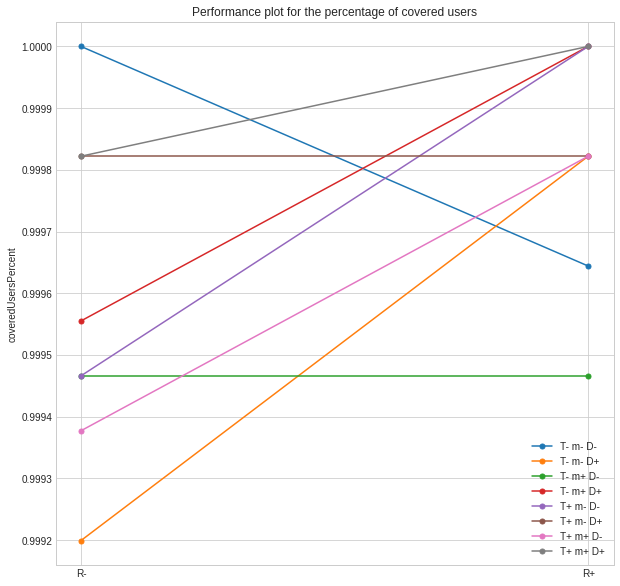

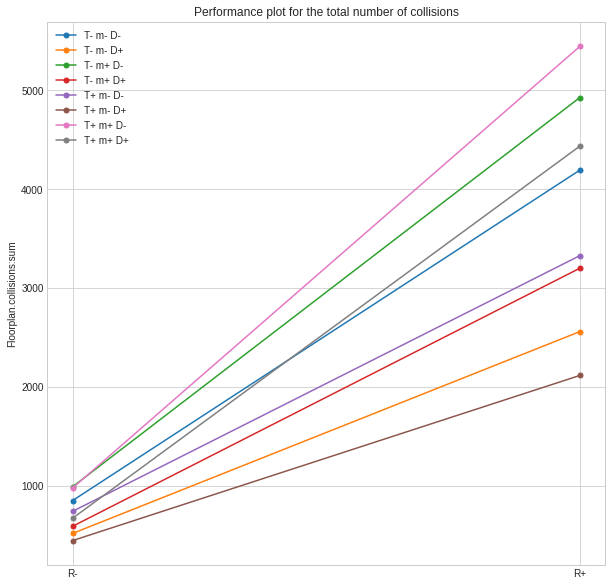

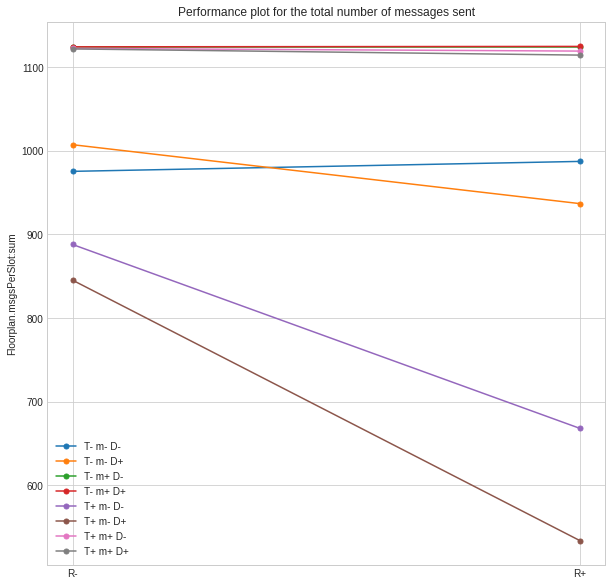

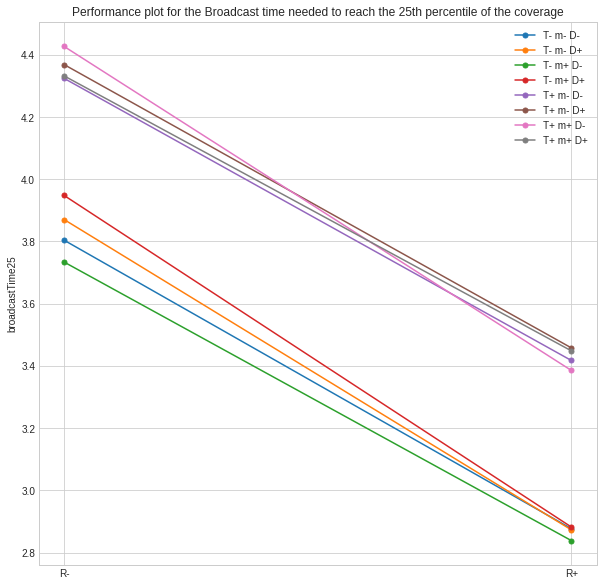

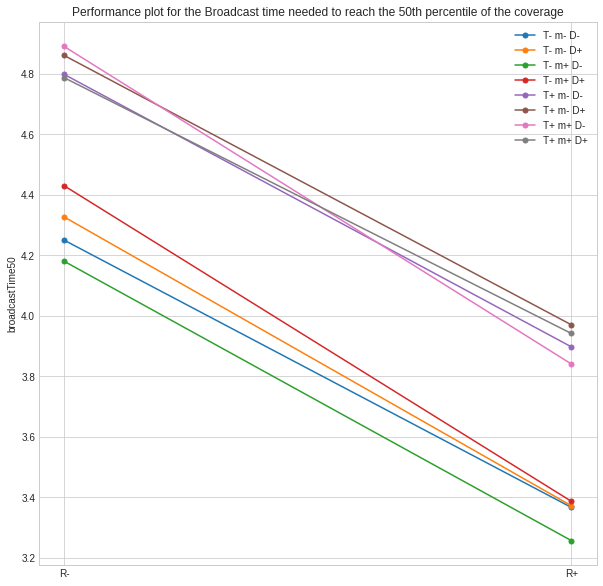

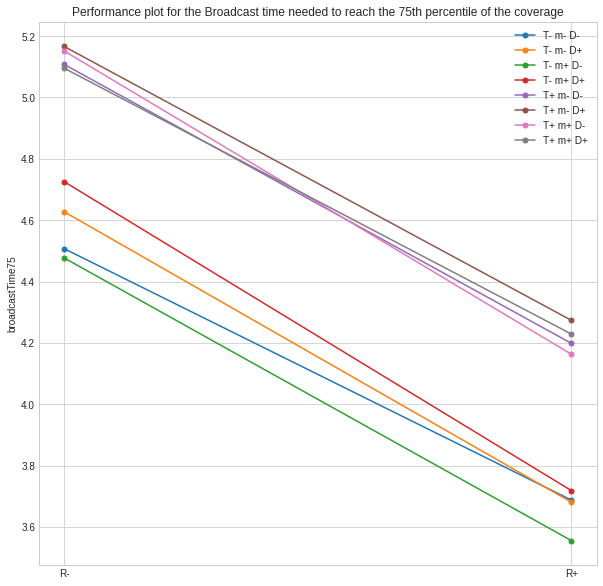

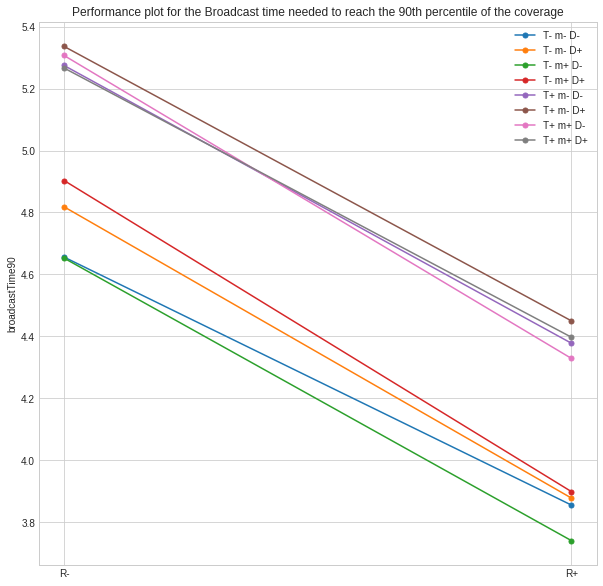

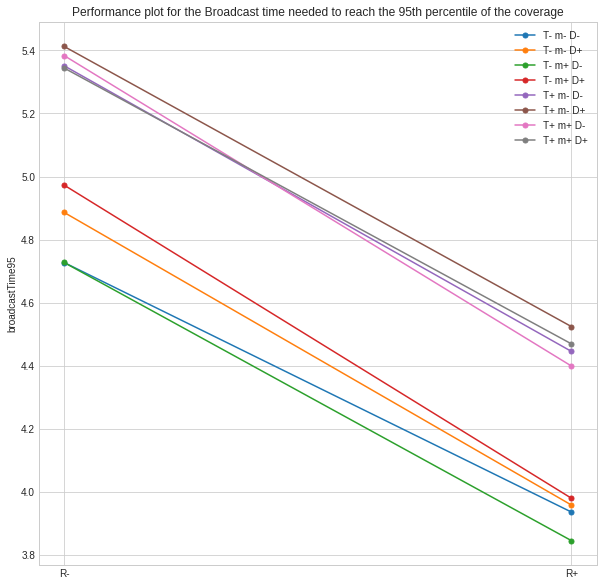

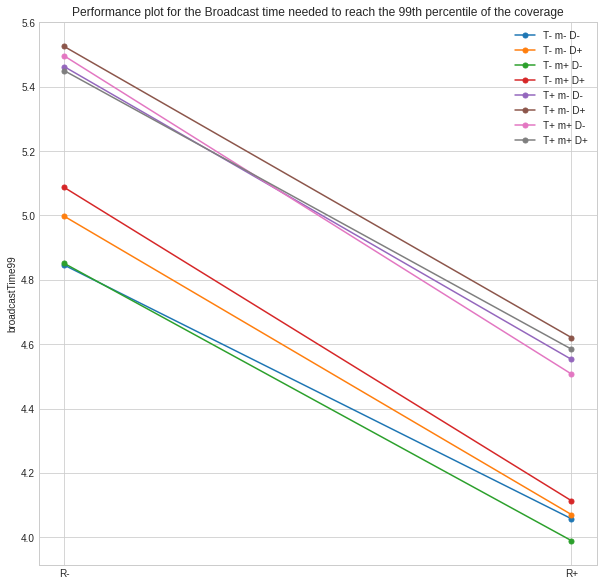

###########################

Plotting with T on the x axis...


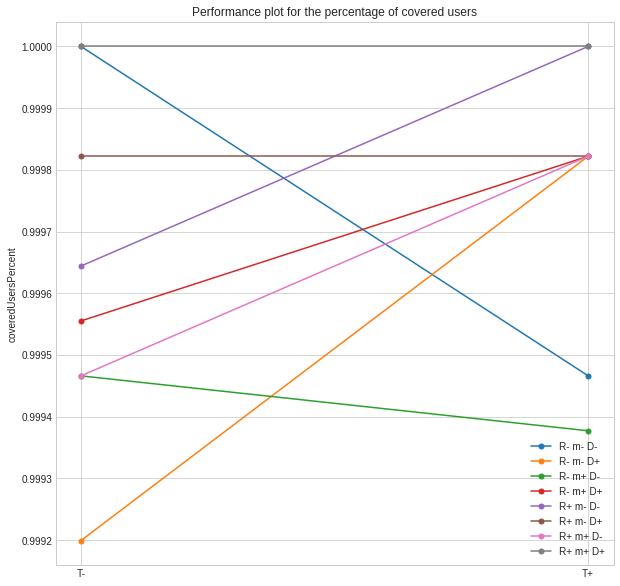

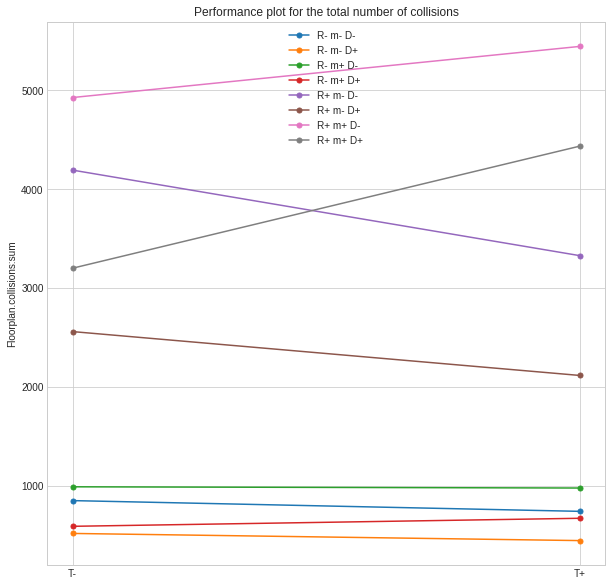

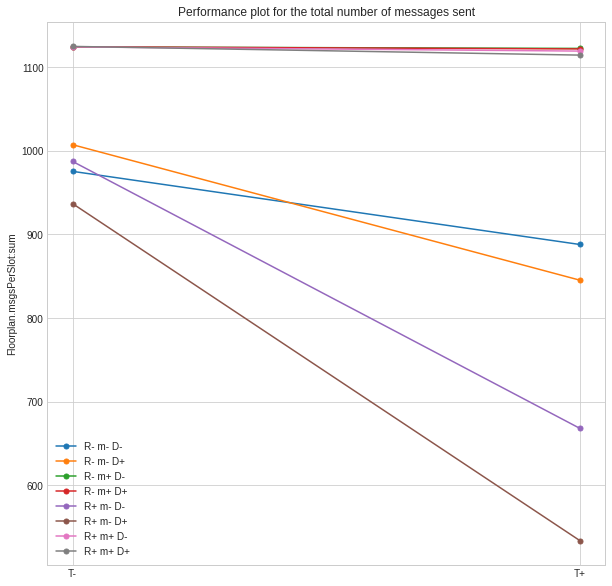

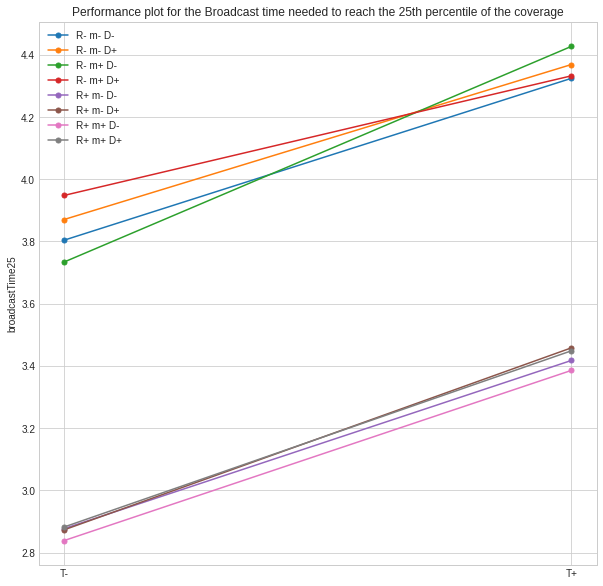

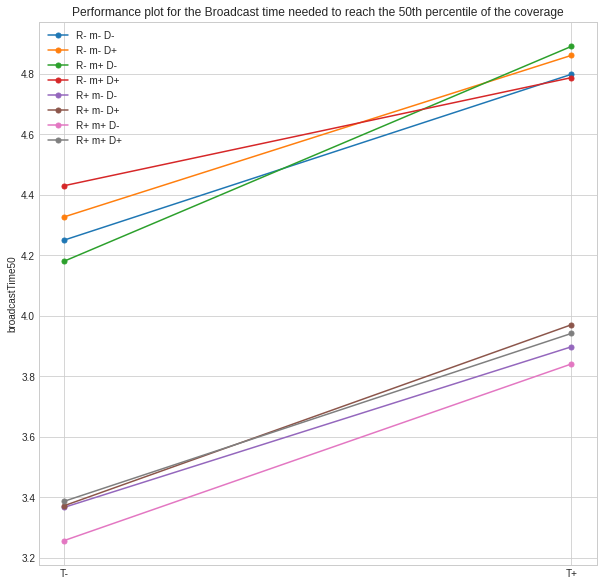

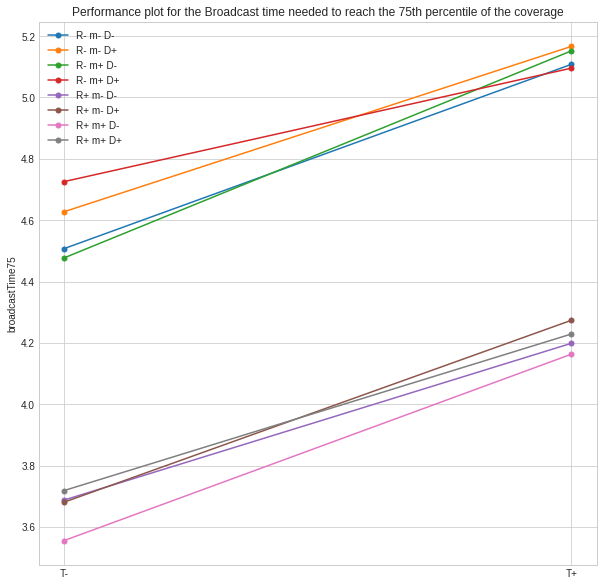

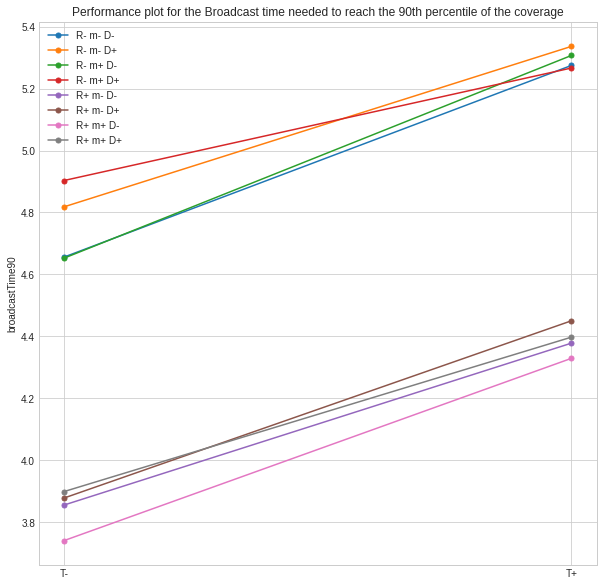

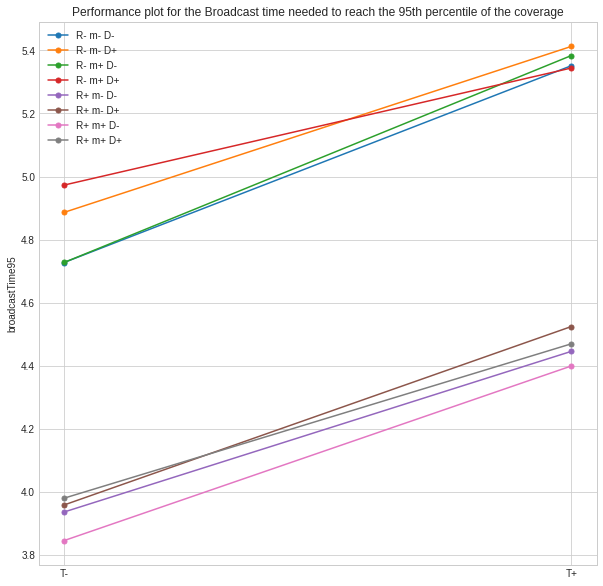

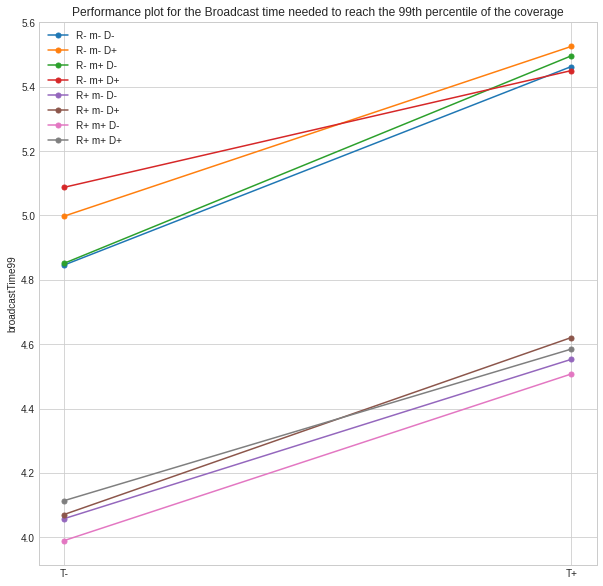

###########################

Plotting with m on the x axis...


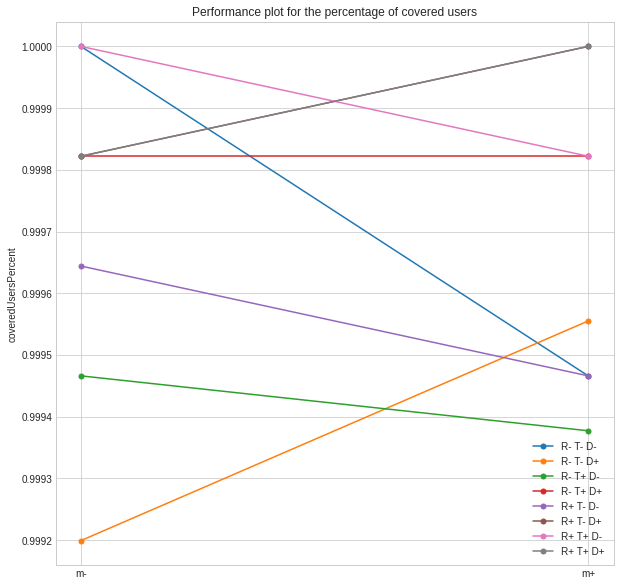

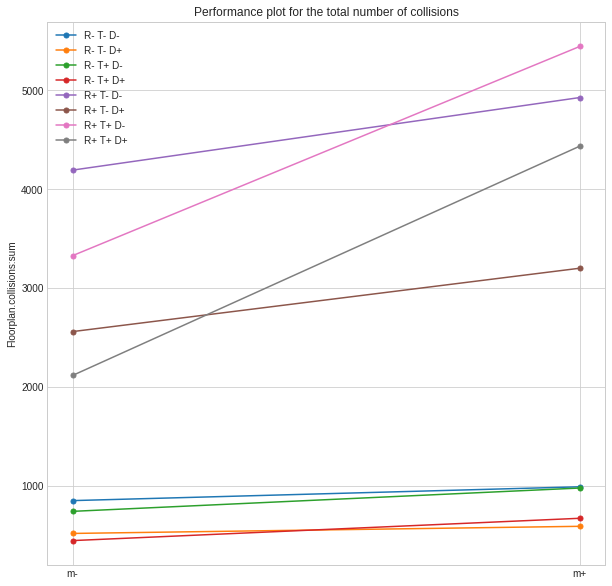

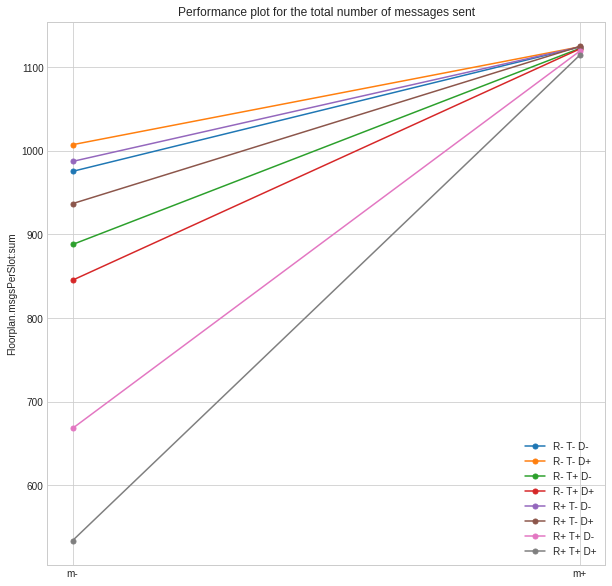

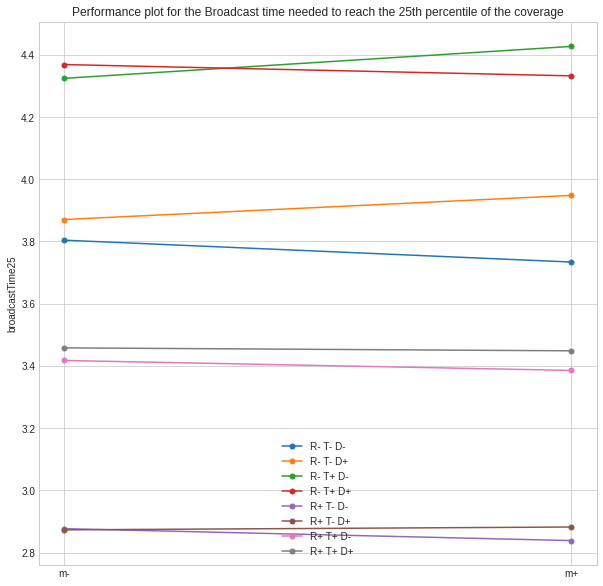

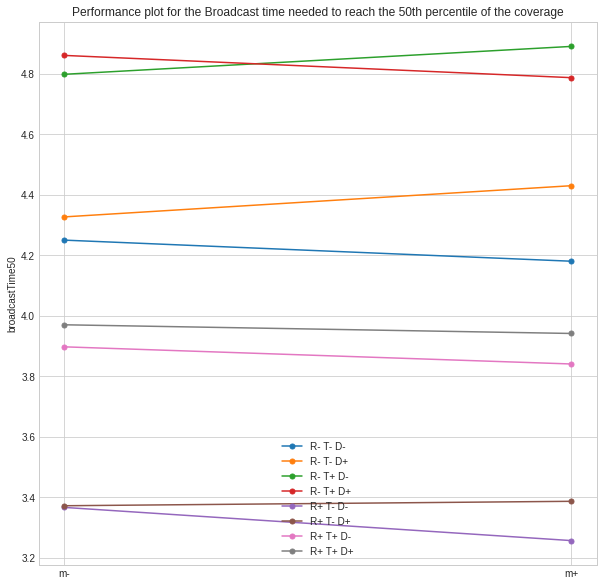

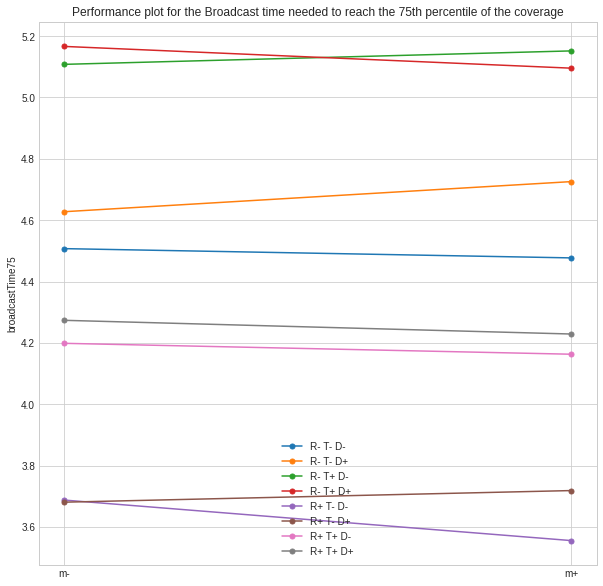

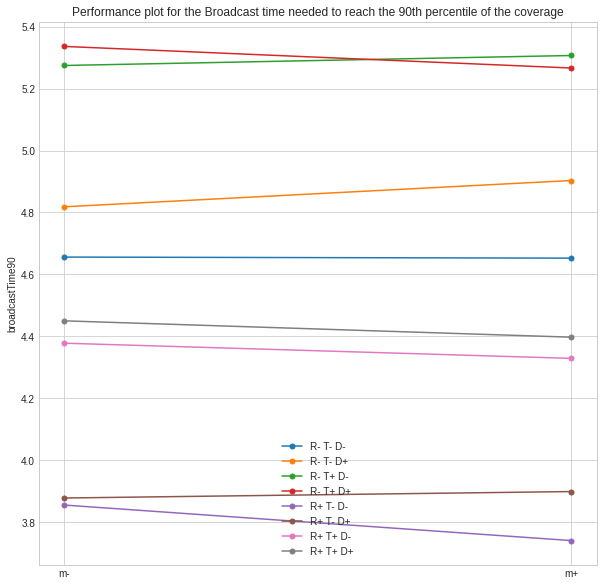

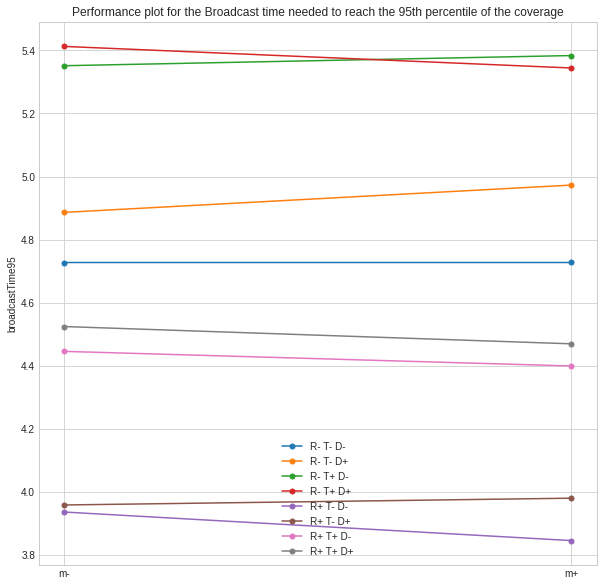

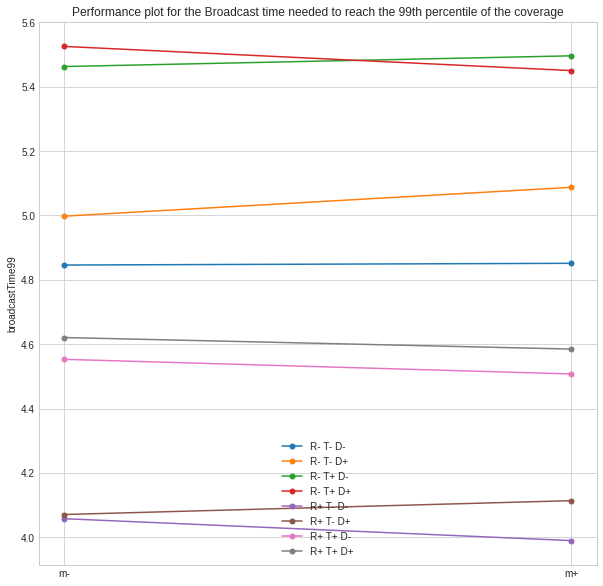

###########################

Plotting with D on the x axis...


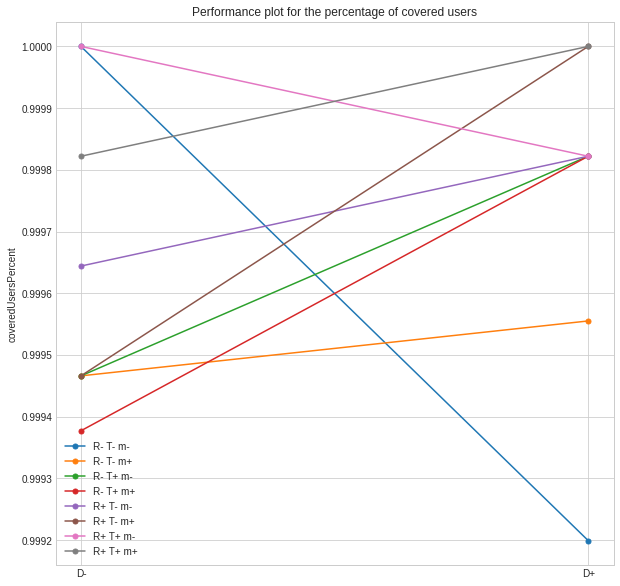

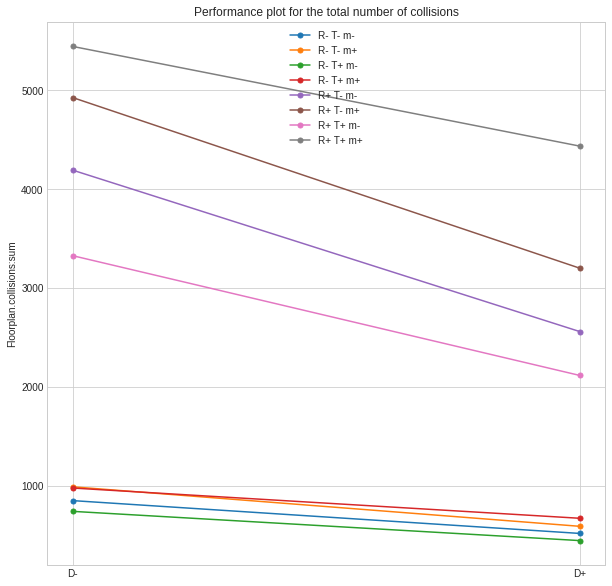

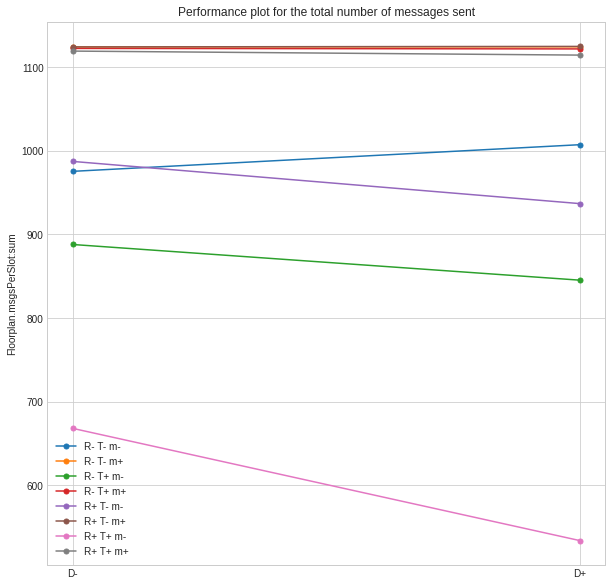

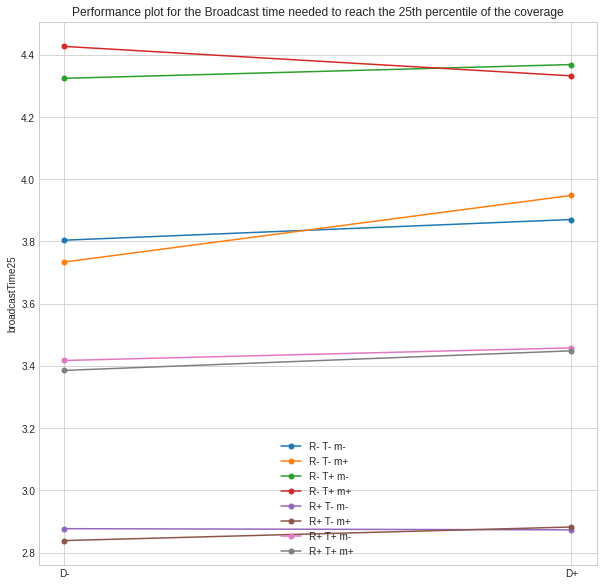

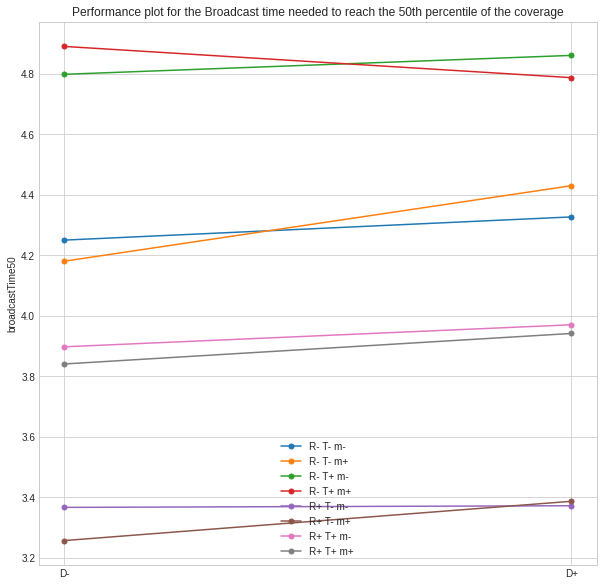

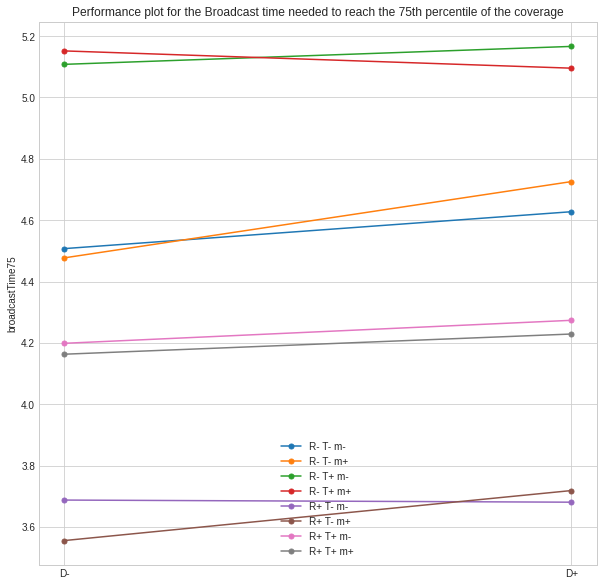

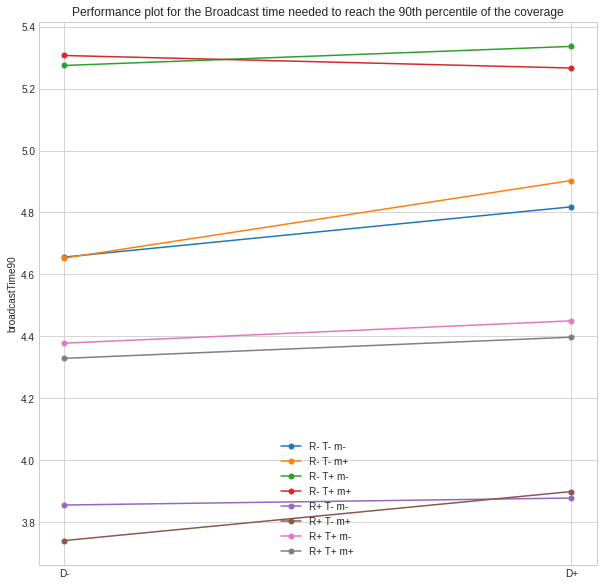

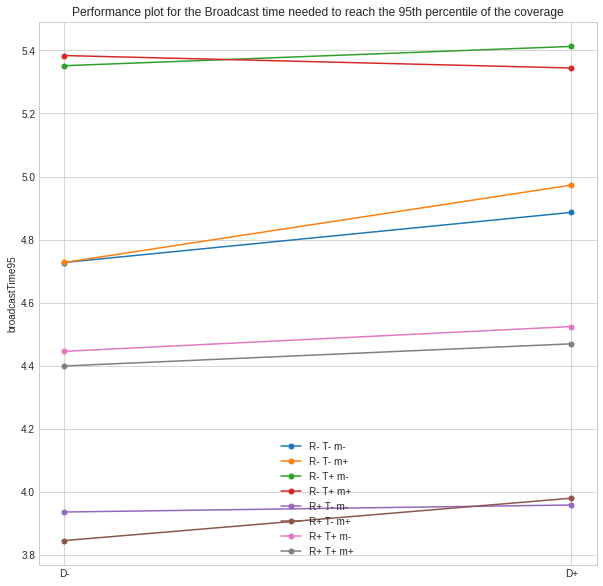

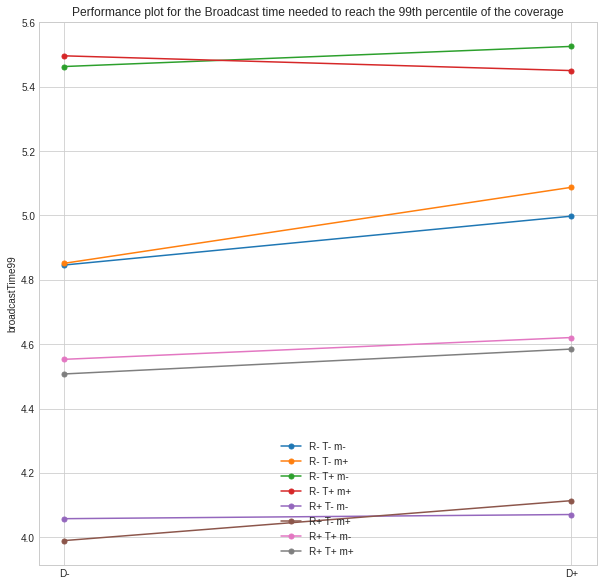

###########################



In [10]:
for xFactor in factors:
    print('Plotting with', xFactor, 'on the x axis...')
    xarr = np.array([-1, 1])
    idx = 0
    factorsMatrix.sort_values([xFactor] + [fac for fac in factors if fac != xFactor], inplace=True)
    for perfIndex, perfIndexDesc in perfIndexes:
        if perfIndex in skipped:
            continue
        ys = []
        fs = []
        for _, row in factorsMatrix.iterrows():
            y = np.sum(row[['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
            fs.append(' '.join([f + str('+' if row[f] == 1 else '-') for f in [fac for fac in factors if fac != xFactor]]))
            ys.append(y)

        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        plt.xticks(xarr, (xFactor + '-', xFactor + '+'))
        ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
        for y, lbl in zip(ys, fs):
            yarr = np.array(y)
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
        plt.title('Performance plot for the ' + perfIndexDesc)
        plt.ylabel(perfIndex)
        plt.legend()
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(perfIndex) + '-' + xFactor + '-perfplot.png')
        plt.show()
        idx += 1
    print('###########################')
    print()

## Notes

First, it is worth noting that in this scenario we are always able to reach the 99% of the coverage. This allows us to study the broadcast time needed to reach the 99% of the network. As we can see from the tables above, the lowest coverage reached is 99.7331% (found in 4 experiments): this percentage means that 1121 out of 1124 reachable users (not counting the first one) has been reached; only 3 nodes have not heard the message.

So, in this scenario, we will not study the coverage since it is always almost perfect and so there is no need to optimize the parameters to increase the coverage.

#### Collisions

Regarding the total number of collisions, we get a very low unexplained variation (0.52%). The most important factor is the broadcast radius (`R`, 78.81%), followed by the max relay delay (`D`, 6.32%) and the maximum number of copies (`m`, 5.56%). Combinations of factors have little or no effect on the number of collisions.

So, to reduce the total number of collisions, we can cleary state that it is necessary to reduce the broadcast radius.

#### Messages sent

For the total number of messages sent, which affects the energy efficiency of the network, we have a low unexplained variation (0.98%). The most important factor is the maximum number of copies (`m`, 58%), followed by the hear window size (`T`, 12.52%). Combinations of the `T` and `m` factors are also important (`Tm`, 11.55%). Also the broadcast radius (`R`) and its combination with the maximum number of copies (`Rm`) have a little influence on the number of messages sent (less that 5% each).

To reduce the total number of messages sent, it is useful to increase the maximum number of copies. Also, the hear window size can be increased to reduce the number of messages sent. As we can see from the performance plot, an increase of the broadcast radius sometimes (not always) leads to a lower number of messages sent.

#### Broadcast time

For the broadcast time, we can see that we generally get an higher unexplained variation, up to 10.88% for the 25th percentile of the coverage. For the 99th percentile of the coverage we get an unexplained variation of 8.03%. So the unexplained variation decreases when the broadcast time is measured for an higher percentile of the coverage: this is expected since random factors that may affect the broadcast time will "shade away" on the long run.

Since we always reach the 99th percentile of the coverage, there is no reason to study the broadcast time for lower percentiles. So we will study this only for the 99% of the coverage.

The reason for the still high unexplained variation can been understood if we think that there is a factor that we (deliberately) do not take into analysis: the *placement* of the user in the 2D floorplan that sends the first message. We will not study this factor here since it is quite hard to analyze it in a 2kr factorial analysis, but we will discuss it in another scenario. To understand why the placement of the first sending user is important first imagine to place it on the center of the 2D floorplan: since the message is sent out radiusly from the user, he can reach other users in each direction around himself (360 degrees angle). If instead we place the first sending user in the corner of the 2D floorplan, the message that it sends out can reach other users only in a quarter of the area compared to the previous case (90 degrees angle). This changes the total broadcast time since, in the second case, the initial phase of the message's spreading is slower.

We can see that, for the total broadcast time, the most important factor is the broadcast radius (`R`, 67.88%), followed by the hear window size (`T`, 22.82%). Other factors and their combinations are irrelevant.

From the performance plots, we can see that to reduce the total broadcast time it is useful to increase the broadcast radius and/or decrease the hear window size.

We must note that for the total broadcast time we have used a *logaritmic transformation of the predicted variable* in order to meet the assumption of finite variance for the residuals (see `2kr-assumptions-tests.ipynb`).